In [1]:
# 讀取模型

from torchsummary import summary
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader
from config import *

with torch.no_grad():
    # Load Dataset
    train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])
    images, labels = torch.tensor([]), torch.tensor([])
    for batch in train_dataloader:
        imgs, lbls = batch
        images = torch.cat((images, imgs))
        labels = torch.cat((labels, lbls))
    print(images.shape, labels.shape)

    # Load Model
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN': RGB_SFMCNN, 'RGB_SFMCNN_V2': RGB_SFMCNN_V2}
    checkpoint_filename = 'RGB_SFMCNN_V2_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth', weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size=(config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)


Code/runs/train/exp
torch.Size([3600, 3, 28, 28]) torch.Size([3600, 9])
triangle
cReLU_percent
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RGB_Conv2d-1             [-1, 30, 6, 6]               0
        RGB_Conv2d-2             [-1, 30, 6, 6]               0
          triangle-3             [-1, 30, 6, 6]               0
          triangle-4             [-1, 30, 6, 6]               0
     cReLU_percent-5             [-1, 30, 6, 6]               0
     cReLU_percent-6             [-1, 30, 6, 6]               0
               SFM-7             [-1, 30, 3, 3]               0
        RBF_Conv2d-8            [-1, 225, 3, 3]           6,750
     cReLU_percent-9            [-1, 225, 3, 3]               0
              SFM-10            [-1, 225, 3, 1]               0
       RBF_Conv2d-11            [-1, 625, 3, 1]         140,625
    cReLU_percent-12            [-1, 625, 3, 1]               0
      Gr

In [40]:
# 可解釋性圖繪製方法
import os
import warnings

from utils import plot_combine_images

warnings.filterwarnings('ignore')
from torchvision import transforms

from pytorch_grad_cam import run_dff_on_image, GradCAM, HiResCAM, GradCAMPlusPlus, GradCAMElementWise, XGradCAM, \
    AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad, DeepFeatureFactorization, KPCA_CAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional, Dict
import matplotlib.pyplot as plt

""" Model wrapper to return a tensor"""


class ModelWrapper(torch.nn.Module):
    """將 Huggingface 模型包裝為返回張量的模型"""
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)



def visualize_all_heatmap(
    model: torch.nn.Module,
    target_layers: dict,
    image: torch.Tensor,
    label: int,
    output_dir: str,
    cam_methods: List[Callable]
) -> None:
    """為所有 CAM 方法生成可視化結果
    
    Args:
        model: 目標模型
        target_layers: 目標層字典
        image: 輸入圖像
        label: 目標標籤
        output_dir: 輸出目錄
        cam_methods: CAM 方法列表
    """
    heatmap_dir = os.path.join(output_dir, 'heatmap')
    os.makedirs(heatmap_dir, exist_ok=True)
    
    for method in cam_methods:
        # try:
        cams = get_each_layers_cam(
            model = model, 
            target_layers = target_layers, 
            label = label,
            input_tensor = image,
            cam_method = method)
        
        plot_cams_on_image(image, cams, heatmap_dir, method.__name__)
            
        # except Exception as e:
        #     print(f"方法 {method.__name__} 執行失敗: {str(e)}")


def get_each_layers_cam(
    model: torch.nn.Module,
    target_layers: dict,
    label: int,
    input_tensor: torch.Tensor,
    cam_method: Callable = GradCAM
):
    wrapped_model = ModelWrapper(model)
    cam_target = ClassifierOutputTarget(label)
    
    cams = {}
    for layer_name in target_layers:
        layer = target_layers[layer_name]
    
        with cam_method(
            model=wrapped_model,
            target_layers=[layer]
        ) as cam:
            # 移除批次處理邏輯，直接使用單個輸入
            input_batch = input_tensor.unsqueeze(0)
            grayscale_cam = cam(input_tensor=input_batch, targets=[cam_target])[0]
            cams[layer_name] = grayscale_cam
            
    return cams


def plot_cams_on_image(
    input_image: torch.Tensor,
    cams: Dict[str, torch.Tensor],
    save_path: str,
    cam_method_name: str
):
    pil_image = transforms.ToPILImage()(input_image)
    
    imgs = {}
    # 添加原始圖像的figure
    fig_raw = plt.figure(figsize=(6, 6))
    plt.imshow(pil_image)  # 確保數據是numpy數組
    plt.axis('off')
    plt.draw()
    plt.close(fig_raw)
    imgs['raw'] = fig_raw

    for layer, cam in cams.items():
        cam_on_image = show_cam_on_image(
            np.float32(pil_image ) / 255,
            cam,
            use_rgb=True
        )
        
        fig = plt.figure(figsize=(6, 6))
        plt.imshow(cam_on_image)
        plt.axis('off')
        plt.draw()
        plt.close(fig)

        imgs[layer] = fig

    output_path = os.path.join(save_path, cam_method_name)
    plot_combine_images(imgs, output_path, show=True)
    

def get_target_layers(model: torch.nn.Module) -> dict:
    """獲取需要分析的目標層
    
    Args:
        model: 目標模型
        
    Returns:
        包含所有目標層的字典
    """
    return {
        'RGB_convs_0': model.RGB_convs[1],
        'RGB_convs_1': model.RGB_convs[2][1],
        'RGB_convs_2': model.RGB_convs[3],
        'Gray_convs_0': model.Gray_convs[0][1],
        'Gray_convs_1': model.Gray_convs[2][1],
        'Gray_convs_2': model.Gray_convs[3]
    }




In [3]:
# 要繪製的模型層

heatmap_layers = get_target_layers(model)
heatmap_layers

{'RGB_convs_0': SFM(
   filter=(2, 2), alpha=[[1.         0.96666664]
    [0.93333334 0.9       ]]
 ),
 'RGB_convs_1': cReLU_percent(percent=0.4000000059604645),
 'RGB_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
   (1): cReLU_percent(percent=0.5)
 ),
 'Gray_convs_0': cReLU_percent(percent=0.30000001192092896),
 'Gray_convs_1': cReLU_percent(percent=0.4000000059604645),
 'Gray_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
   (1): cReLU_percent(percent=0.5)
 )}

In [14]:
cam.shape

(28, 28)

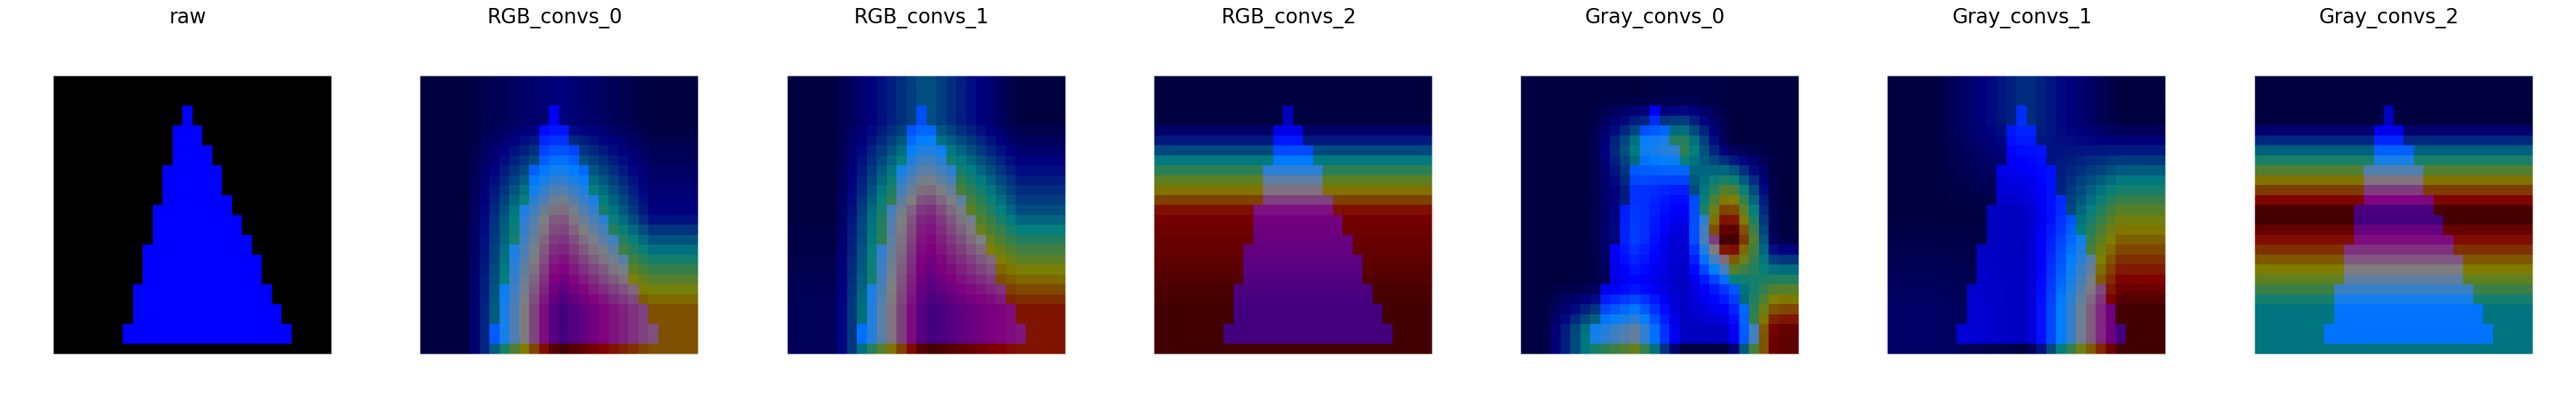

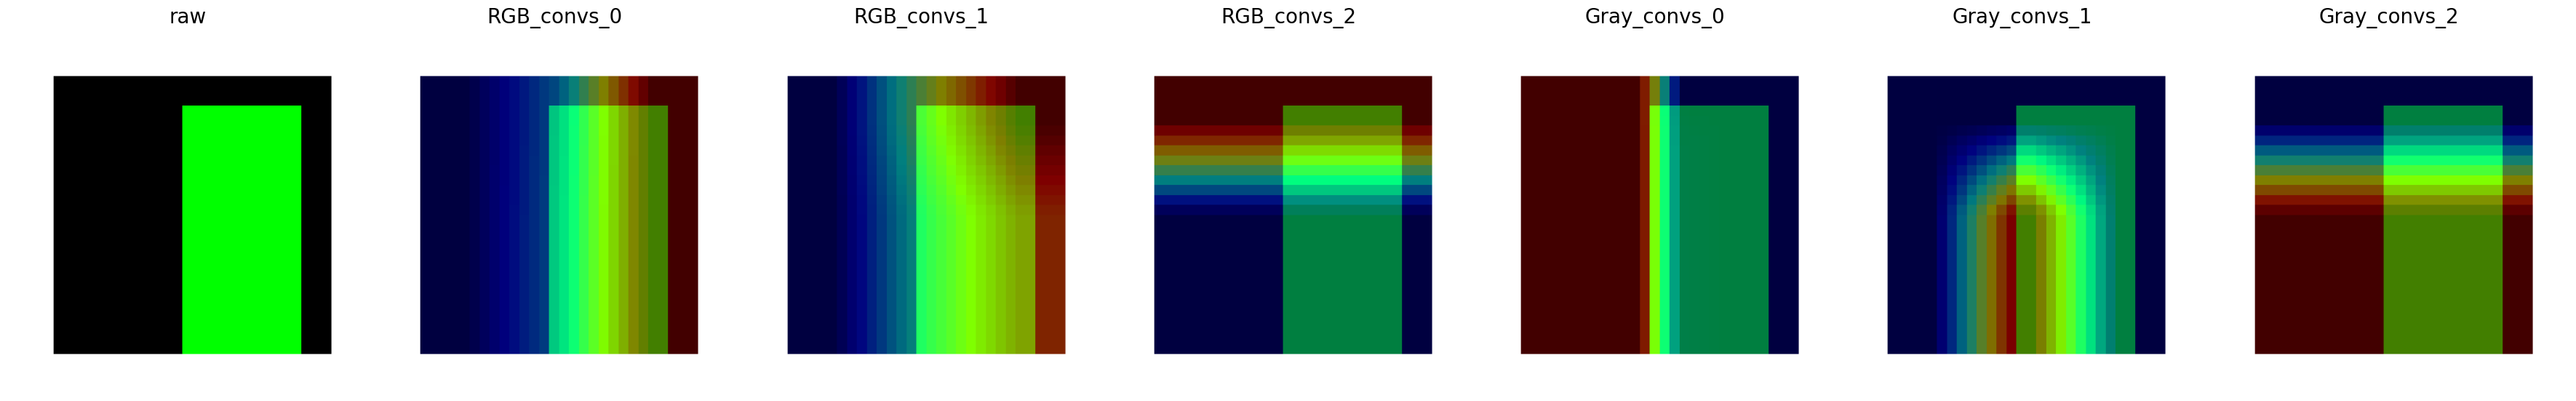

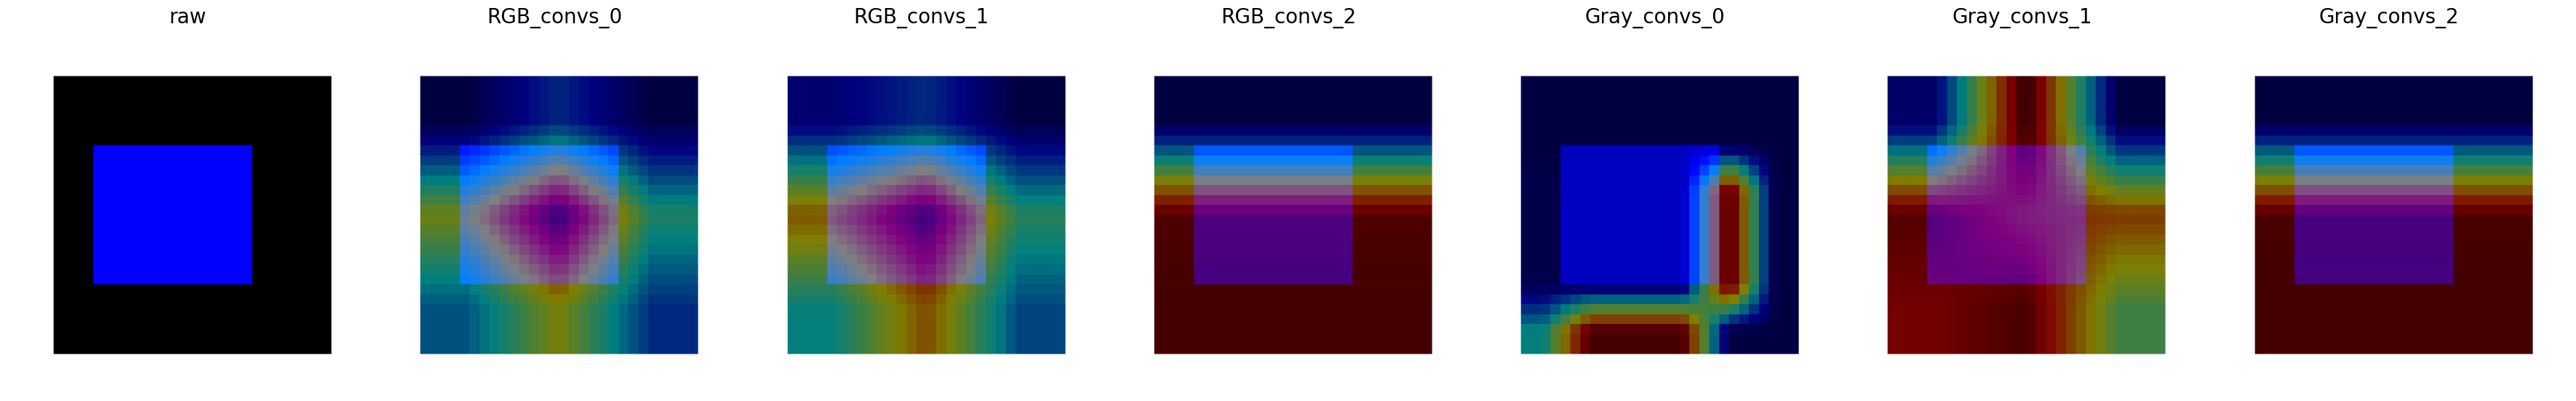

In [27]:
from utils import plot_combine_images

# 繪製圖

# save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/{label.argmax().item()}/example_{test_id}/'
save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/'

heatmap_methods = [GradCAM]
# heatmap_methods = [GradCAM, HiResCAM, GradCAMPlusPlus, GradCAMElementWise, XGradCAM, AblationCAM,
#                    ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, KPCA_CAM]


for i in range(0, 3):
    image = images[i]
    label = labels[i].argmax().item()
    
    heatmap_save = f'{save_path}/{label}/{i}/heatmap/'
    os.makedirs(heatmap_save, exist_ok=True)
    
    
    visualize_all_heatmap(model, heatmap_layers, image, label, save_path, heatmap_methods)
            
    

In [28]:
from PIL import Image
import torch
import torchvision
import random
import torch.nn.functional as F
import numpy as np
from pytorch_grad_cam import ( GradCAM, HiResCAM, GradCAMPlusPlus,
                              GradCAMElementWise, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM,
                              LayerCAM, KPCA_CAM)

from torchsummary import summary
from torch import nn

from config import *
from plot_cam import visualize_all_heatmap, get_cam_target_layers
from utils import *
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader

import matplotlib

# 繪製熱圖
PLOT_HEATMAP = True

FMs = {}
if arch['args']['in_channels'] == 1:
    FMs[0] = model.convs[0][0].weight.reshape(-1, *arch['args']['Conv2d_kernel'][0], 1)
    print(f'FM[0] shape: {FMs[0].shape}')
    FMs[1] = model.convs[1][0].weight.reshape(-1, int(model.convs[1][0].weight.shape[1] ** 0.5),
                                              int(model.convs[1][0].weight.shape[1] ** 0.5), 1)
    print(f'FM[1] shape: {FMs[1].shape}')
    FMs[2] = model.convs[2][0].weight.reshape(-1, int(model.convs[2][0].weight.shape[1] ** 0.5),
                                              int(model.convs[2][0].weight.shape[1] ** 0.5), 1)
    print(f'FM[2] shape: {FMs[2].shape}')
    FMs[3] = model.convs[3][0].weight.reshape(-1, int(model.convs[3][0].weight.shape[1] ** 0.5),
                                              int(model.convs[3][0].weight.shape[1] ** 0.5), 1)
    print(f'FM[3] shape: {FMs[3].shape}')
else:
    # 平行架構
    kernel_size = arch['args']['Conv2d_kernel'][0]
    weights = torch.concat([model.RGB_convs[0][0].transform_weights()])
    weights = weights.reshape(arch['args']['channels'][0][0], arch['args']['in_channels'], 1, 1)
    weights = weights.repeat(1, 1, *kernel_size)
    FMs['RGB_convs_0'] = weights
    print(f'FM[RGB_convs_0] shape: {FMs["RGB_convs_0"].shape}')

    FMs['RGB_convs_1'] = model.RGB_convs[2][0].weight.reshape(-1, 2, 15, 1)
    print(f'FM[RGB_convs_1] shape: {FMs["RGB_convs_1"].shape}')

    FMs['RGB_convs_2'] = model.RGB_convs[3][0].weight.reshape(-1, int(model.RGB_convs[3][0].weight.shape[1] ** 0.5),
                                                              int(model.RGB_convs[3][0].weight.shape[1] ** 0.5), 1)
    print(f'FM[RGB_convs_2] shape: {FMs["RGB_convs_2"].shape}')

    FMs['Gray_convs_0'] = model.Gray_convs[0][0].weight.reshape(arch['args']['channels'][1][0], 1, *kernel_size)
    print(f'FM[Gray_convs_0] shape: {FMs["Gray_convs_0"].shape}')
    FMs['Gray_convs_1'] = model.Gray_convs[2][0].weight.reshape(-1, 7, 10, 1)
    print(f'FM[Gray_convs_1] shape: {FMs["Gray_convs_1"].shape}')
    FMs['Gray_convs_2'] = model.Gray_convs[3][0].weight.reshape(-1, int(model.Gray_convs[3][0].weight.shape[1] ** 0.5),
                                                                int(model.Gray_convs[3][0].weight.shape[1] ** 0.5), 1)
    print(f'FM[Gray_convs_2] shape: {FMs["Gray_convs_2"].shape}')

layers = get_layers(model)

CIs = {}
kernel_size = arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0])
if arch['args']['in_channels'] == 1:
    CIs[0], CI_idx, CI_values = get_ci(images, layers[0], kernel_size=kernel_size, stride=stride)
    CIs[1], CI_idx, CI_values = get_ci(images, layers[1], kernel_size=kernel_size, stride=stride,
                                       sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]), dim=0))
    CIs[2], CI_idx, CI_values = get_ci(images, layers[2], kernel_size=kernel_size, stride=stride,
                                       sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]), dim=0))
    CIs[3], CI_idx, CI_values = get_ci(images, layers[3], kernel_size=kernel_size, stride=stride,
                                       sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:3]), dim=0))
else:

    CIs["RGB_convs_0"], CI_idx, CI_values = get_ci(images, layers['RGB_convs_0'], kernel_size, stride=stride)
    CIs["RGB_convs_1"], CI_idx, CI_values = get_ci(images, layers["RGB_convs_1"], kernel_size=kernel_size,
                                                   stride=stride,
                                                   sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]),
                                                                         dim=0))
    CIs["RGB_convs_2"], CI_idx, CI_values = get_ci(images, layers["RGB_convs_2"], kernel_size=kernel_size,
                                                   stride=stride,
                                                   sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]),
                                                                         dim=0))

    CIs["Gray_convs_0"], CI_idx, CI_values = get_ci(model.gray_transform(images), layers['Gray_convs_0'], kernel_size,
                                                    stride=stride)
    CIs["Gray_convs_1"], CI_idx, CI_values = get_ci(model.gray_transform(images), layers["Gray_convs_1"],
                                                    kernel_size=kernel_size, stride=stride,
                                                    sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]),
                                                                          dim=0))
    CIs["Gray_convs_2"], CI_idx, CI_values = get_ci(model.gray_transform(images), layers["Gray_convs_2"],
                                                    kernel_size=kernel_size, stride=stride,
                                                    sfm_filter=torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]),
                                                                          dim=0))

if config['dataset'] == 'Colored_MNIST' or config['dataset'] == 'Colored_FashionMNIST':
    label_to_idx = {}
    i = 0
    for c in ['red', 'green', 'blue']:
        for n in range(10):
            label_to_idx[c + '_' + str(n)] = i
            i += 1
    idx_to_label = {value: key for key, value in label_to_idx.items()}
elif config['dataset'] == 'AnotherColored_MNIST' or config['dataset'] == 'AnotherColored_FashionMNIST':
    label_to_idx = {}
    colors = {
        'brown': [151, 74, 0],
        'light_blue': [121, 196, 208],
        'light_pink': [221, 180, 212]
    }
    i = 0
    for c in colors.keys():
        for n in range(10):
            label_to_idx[c + '_' + str(n)] = i
            i += 1
    idx_to_label = {value: key for key, value in label_to_idx.items()}

example_num = 450


# 繪製反應 RM 圖，並存到陣列中
def plot_RM_then_save(layer_num, plot_shape, img, save_path, is_gray = False, figs = None):
    fig = plot_RM_map(layer_num, plot_shape, img, save_path, is_gray)

    if figs is not None:
        figs[layer_num] = fig

# 繪製反應 RM 圖
def plot_RM_map(layer_num, plot_shape, img, save_path, is_gray = False):

    if is_gray:
        RM = layers[layer_num](model.gray_transform(img.unsqueeze(0)))[0]
    else:
        RM = layers[layer_num](img.unsqueeze(0))[0]

    # print(f"Layer{layer_num}_RM: {RM.shape}")

    RM_H, RM_W = RM.shape[1], RM.shape[2]
    return plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
             path=save_path + f'{layer_num}_RM')


save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example'
if os.path.exists(save_path):
    shutil.rmtree(save_path)  # 刪除資料夾及其內容
    os.makedirs(save_path)  # 重新建立資料夾





FM[RGB_convs_0] shape: torch.Size([30, 3, 5, 5])
FM[RGB_convs_1] shape: torch.Size([225, 2, 15, 1])
FM[RGB_convs_2] shape: torch.Size([625, 15, 15, 1])
FM[Gray_convs_0] shape: torch.Size([70, 1, 5, 5])
FM[Gray_convs_1] shape: torch.Size([625, 7, 10, 1])
FM[Gray_convs_2] shape: torch.Size([1225, 25, 25, 1])
segments shape: torch.Size([129600, 5, 5, 3])
output shape: torch.Size([129600, 30])
segments shape: torch.Size([32400, 10, 10, 3])
output shape: torch.Size([32400, 225])
segments shape: torch.Size([10800, 10, 30, 3])
output shape: torch.Size([10800, 625])
segments shape: torch.Size([129600, 5, 5, 1])
output shape: torch.Size([129600, 70])
segments shape: torch.Size([32400, 10, 10, 1])
output shape: torch.Size([32400, 625])
segments shape: torch.Size([10800, 10, 30, 1])
output shape: torch.Size([10800, 1225])


In [29]:
def process_image(image, label, test_id):
    print(test_id)
    save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/{label.argmax().item()}/example_{test_id}/'
    RM_save_path = f'{save_path}/RMs/'
    RM_CI_save_path = f'{save_path}/RM_CIs/'
    os.makedirs(RM_save_path, exist_ok=True)
    os.makedirs(RM_CI_save_path, exist_ok=True)

    if arch['args']['in_channels'] == 1:
        torchvision.utils.save_image(image, save_path + f'origin_{test_id}.png')
    else:
        plt.imsave(save_path + f'origin_{test_id}.png', image.permute(1, 2, 0).detach().numpy())

    segments = split(image.unsqueeze(0), kernel_size=arch['args']['Conv2d_kernel'][0],
                     stride=(arch['args']['strides'][0], arch['args']['strides'][0]))[0]

    RM_CIs = {}

    RM_figs = {}

    RM_CI_figs = {}

    fig = plot_map(segments.permute(1, 2, 3, 4, 0), path=save_path + f'origin_split_{test_id}.png')
    RM_figs['Origin_Split'] = fig
    RM_CI_figs['Origin_Split'] =  fig

    if arch['args']['in_channels'] == 1:
        # Layer 0
        layer_num = 0
        RM = layers[layer_num](image.unsqueeze(0))[0]
        print(f"Layer{layer_num}_RM: {RM.shape}")
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5),
                                             1).detach().numpy(), path=RM_save_path + f'{layer_num}_RM')
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, 1)
        plot_map(RM_CI.detach().numpy(), path=RM_CI_save_path + f'Layer{layer_num}_RM_CI', cmap='gray')
        RM_CIs[layer_num] = RM_CI

        # Layer 1
        layer_num = 1
        RM = layers[layer_num](image.unsqueeze(0))[0]
        print(f"Layer{layer_num}_RM: {RM.shape}")
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5),
                                             1).detach().numpy(), path=RM_save_path + f'{layer_num}_RM')
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        plot_map(RM_CI.detach().numpy(), path=RM_CI_save_path + f'Layer{layer_num}_RM_CI', cmap='gray')
        RM_CIs[layer_num] = RM_CI

        # Layer 2
        layer_num = 2
        RM = layers[layer_num](image.unsqueeze(0))[0]
        print(f"Layer{layer_num}_RM: {RM.shape}")
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5),
                                             1).detach().numpy(), path=RM_save_path + f'{layer_num}_RM')
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        plot_map(RM_CI.detach().numpy(), path=RM_CI_save_path + f'Layer{layer_num}_RM_CI', cmap='gray')
        RM_CIs[layer_num] = RM_CI

        # Layer 3
        layer_num = 3
        RM = layers[layer_num](image.unsqueeze(0))[0]
        print(f"Layer{layer_num}_RM: {RM.shape}")
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5),
                                             1).detach().numpy(), path=RM_save_path + f'{layer_num}_RM')
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        plot_map(RM_CI.detach().numpy(), path=RM_CI_save_path + f'Layer{layer_num}_RM_CI', cmap='gray')
        RM_CIs[layer_num] = RM_CI


    else:
        ################################### RGB ###################################
        ### RGB_convs_0 ###
        # 跑完響應模組，SFM 合併前
        layer_num = 'RGB_convs_0'
        plot_shape = (5, 6)

        # 繪製只跑 Conv(卷積) 的 RM
        plot_RM_then_save('RGB_convs_0_Conv', plot_shape, image, RM_save_path,
                          False, RM_figs)

        RM = layers[layer_num](image.unsqueeze(0))[0]
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        FM_H, FM_W = FMs[layer_num].shape[2], FMs[layer_num].shape[3]
        RM_FM = FMs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].permute(0, 2, 3, 1).reshape(
            RM_H, RM_W, FM_H, FM_W, arch['args']['in_channels'])
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        RM_CI_figs[layer_num] = plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI_origin')
        RM_CI = RM_CI.permute(0, 1, 4, 2, 3).reshape(*RM_CI.shape[:2], arch['args']['in_channels'], -1).mean(
            dim=-1).unsqueeze(-2).unsqueeze(-2).repeat(1, 1, *RM_CI.shape[2:4], 1)


        RM_CIs[layer_num] = RM_CI
        # 繪製 RM
        fig = plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                 path=RM_save_path + f'{layer_num}_RM')
        RM_figs[layer_num] = fig


        plot_map(RM_FM.detach().numpy(), path=RM_CI_save_path + f'{layer_num}_RM_FM')
        plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI')


        # 繪製 SFM 合併後的 RM
        plot_RM_then_save('RGB_convs_0_SFM', plot_shape, image, RM_save_path,
                          False, RM_figs)

        ### RGB_convs_1 ###
        # 跑完響應模組，SFM 合併前
        layer_num = 'RGB_convs_1'
        RM = layers[layer_num](image.unsqueeze(0))[0]
        plot_shape = (int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5))
        # 繪製 只跑 Conv(卷積) 的 RM
        plot_RM_then_save('RGB_convs_1_Conv', plot_shape, image, RM_save_path,
                          False, RM_figs)

        print(f"Layer{layer_num}_RM: {RM.shape}")
        # 存RM_FM、RM_CI
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        RM_CI_figs[layer_num] = plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI_origin')
        # 將RM_CI取每個小圖的代表色塊後合併成為新的RM_CI
        RM_CI = RM_CI.reshape(RM_H, RM_W, CI_H // RM_CIs['RGB_convs_0'].shape[2], RM_CIs['RGB_convs_0'].shape[2],
                              CI_W // RM_CIs['RGB_convs_0'].shape[3], RM_CIs['RGB_convs_0'].shape[3],
                              arch['args']['in_channels'])
        RM_CI = RM_CI.permute(0, 2, 1, 4, 3, 5, 6)
        RM_CI = RM_CI.reshape(RM_CIs['RGB_convs_0'].shape)
        RM_CI = RM_CI.permute(0, 1, 4, 2, 3).reshape(*RM_CI.shape[:2], arch['args']['in_channels'], -1).mean(
            dim=-1).unsqueeze(-2).unsqueeze(-2).repeat(1, 1, *RM_CI.shape[2:4], 1)
        RM_CI = RM_CI.reshape(RM_H, RM_CI.shape[0] // RM_H, RM_W, RM_CI.shape[1] // RM_W, *RM_CI.shape[2:])
        RM_CI = RM_CI.permute(0, 2, 1, 4, 3, 5, 6).reshape(RM_H, RM_W, CI_H, CI_W, 3)
        RM_CIs[layer_num] = RM_CI
        plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI')
        # 繪製 RM
        fig = plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                 path=RM_save_path + f'{layer_num}_RM')
        RM_figs[layer_num] = fig


        # 繪製 SFM 合併後的 RM
        plot_RM_then_save('RGB_convs_1_SFM', plot_shape, image, RM_save_path,
                          False, RM_figs)

        ### RGB_convs_2
        # 跑完響應模組，SFM 合併前
        layer_num = 'RGB_convs_2'
        RM = layers[layer_num](image.unsqueeze(0))[0]
        plot_shape = (int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5))
        print(f"Layer{layer_num}_RM: {RM.shape}")
        # 繪製只跑 Conv(卷積) 的 RM
        plot_RM_then_save('RGB_convs_2_Conv', plot_shape, image, RM_save_path,
                          False, RM_figs)

        # 存RM_FM、RM_CI
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, arch['args'][
                                                                                                       'in_channels'])
        RM_CI_figs[layer_num] = plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI_origin')
        # 將RM_CI取每個小圖的代表色塊後合併成為新的RM_CI
        RM_CI = RM_CI.reshape(RM_H, RM_W, CI_H // RM_CIs['RGB_convs_0'].shape[2], RM_CIs['RGB_convs_0'].shape[2],
                              CI_W // RM_CIs['RGB_convs_0'].shape[3], RM_CIs['RGB_convs_0'].shape[3],
                              arch['args']['in_channels'])
        RM_CI = RM_CI.permute(0, 2, 1, 4, 3, 5, 6)
        RM_CI = RM_CI.reshape(RM_CIs['RGB_convs_0'].shape)
        RM_CI = RM_CI.permute(0, 1, 4, 2, 3).reshape(*RM_CI.shape[:2], arch['args']['in_channels'], -1).mean(
            dim=-1).unsqueeze(-2).unsqueeze(-2).repeat(1, 1, *RM_CI.shape[2:4], 1)
        RM_CI = RM_CI.reshape(RM_H, RM_CI.shape[0] // RM_H, RM_W, RM_CI.shape[1] // RM_W, *RM_CI.shape[2:])
        RM_CI = RM_CI.permute(0, 2, 1, 4, 3, 5, 6).reshape(RM_H, RM_W, CI_H, CI_W, 3)
        RM_CIs[layer_num] = RM_CI
        plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI')
        # 繪製 RM
        fig = plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                       path=RM_save_path + f'{layer_num}_RM')
        RM_figs[layer_num] = fig

        ################################### Gray ###################################
        ### Gray_convs_0 ###
        # 跑完響應模組，SFM 合併前
        layer_num = 'Gray_convs_0'
        plot_shape = (7, 10)
        RM = layers[layer_num](model.gray_transform(image.unsqueeze(0)))[0]
        print(f"{layer_num}_RM: {RM.shape}")
        # 存RM_FM、RM_CI
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, 1)
        RM_CIs[layer_num] = RM_CI
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                 path=RM_save_path + f'{layer_num}_RM')
        RM_CI_figs[layer_num] = plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI', cmap='gray')

        # 只跑 Conv(卷積)
        plot_RM_map('Gray_convs_0_Conv', plot_shape, image, RM_save_path, is_gray = True)
        # SFM 合併後
        plot_RM_map('Gray_convs_0_SFM', plot_shape, image, RM_save_path, is_gray = True)


        ### Gray_convs_1 ###
        # 跑完響應模組，SFM 合併前
        layer_num = 'Gray_convs_1'
        RM = layers[layer_num](model.gray_transform(image.unsqueeze(0)))[0]
        plot_shape = (int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5))
        print(f"Layer{layer_num}_RM: {RM.shape}")
        # 存RM_FM、RM_CI
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, 1)
        RM_CIs[layer_num] = RM_CI
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                 path=RM_save_path + f'{layer_num}_RM')
        RM_CI_figs[layer_num] = plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI', cmap='gray')

        # 只跑 Conv(卷積)
        plot_RM_map('Gray_convs_1_Conv', plot_shape, image, RM_save_path, is_gray=True)
        # SFM 合併後
        plot_RM_map('Gray_convs_1_SFM', plot_shape, image, RM_save_path, is_gray=True)


        ### Gray_convs_2 ###
        # 跑完響應模組，SFM 合併前
        layer_num = 'Gray_convs_2'
        RM = layers[layer_num](model.gray_transform(image.unsqueeze(0)))[0]
        plot_shape = (int(RM.shape[0] ** 0.5), int(RM.shape[0] ** 0.5))
        print(f"Layer{layer_num}_RM: {RM.shape}")
        # 存RM_FM、RM_CI
        RM_H, RM_W = RM.shape[1], RM.shape[2]
        CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
        RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H, RM_W, CI_H,
                                                                                                   CI_W, 1)
        RM_CIs[layer_num] = RM_CI
        plot_map(RM.permute(1, 2, 0).reshape(RM_H, RM_W, *plot_shape, 1).detach().numpy(),
                 path=RM_save_path + f'{layer_num}_RM')
        RM_CI_figs[layer_num] =plot_map(RM_CI, path=RM_CI_save_path + f'{layer_num}_RM_CI', cmap='gray')

        # 只跑 Conv(卷積)
        plot_RM_map('Gray_convs_2_Conv', plot_shape, image, RM_save_path, is_gray=True)

        plot_combine_images(RM_figs, RM_save_path + f'RGB_combine')
        plot_combine_images(RM_CI_figs, RM_CI_save_path + f'combine')

        ################################### heatmap ###################################

    plt.close('all')
    
    return RM_CIs


In [31]:
i = 0
image = images[i]
label = labels[i]


RM_CIs = process_image(image, label, i)

0
LayerRGB_convs_1_RM: torch.Size([225, 3, 3])
LayerRGB_convs_2_RM: torch.Size([625, 3, 1])
Gray_convs_0_RM: torch.Size([70, 6, 6])
LayerGray_convs_1_RM: torch.Size([625, 3, 3])
LayerGray_convs_2_RM: torch.Size([1225, 3, 1])


In [33]:
for name, RM_CI in RM_CIs.items():
    print(f"{name}, {RM_CI.shape}")

RGB_convs_0, torch.Size([6, 6, 5, 5, 3])
RGB_convs_1, torch.Size([3, 3, 10, 10, 3])
RGB_convs_2, torch.Size([3, 1, 10, 30, 3])
Gray_convs_0, torch.Size([6, 6, 5, 5, 1])
Gray_convs_1, torch.Size([3, 3, 10, 10, 1])
Gray_convs_2, torch.Size([3, 1, 10, 30, 1])


In [35]:
method = GradCAM

label_arg = label.argmax().item()

cams = get_each_layers_cam(
        model = model, 
        target_layers = heatmap_layers, 
        label = label_arg,
        input_tensor = image,
        cam_method = method)

In [42]:


# 範例資料
cam = np.random.rand(10, 7)  # cam.shape = (10, 7)
output_shape = (3, 1)        # 目標縮減形狀

reduced = get_reduced_cam(cam, output_shape)
print("Reduced cam:\n", reduced)

Reduced cam:
 [[0.58844517]
 [0.48129995]
 [0.45012355]]


RGB_convs_0, torch.Size([6, 6, 5, 5, 3]), (28, 28)
[[0.         0.03654363 0.09845285 0.07523689 0.01773441 0.        ]
 [0.         0.09199864 0.2482834  0.20439786 0.07872827 0.03997036]
 [0.         0.18885843 0.5100433  0.43210247 0.19005391 0.11540344]
 [0.         0.25265276 0.6844524  0.6523334  0.42313105 0.35244256]
 [0.         0.29524112 0.80220354 0.8454749  0.6835942  0.63366836]
 [0.         0.30837584 0.8385193  0.90504205 0.763924   0.7204016 ]]
./detect/MultiColor_Shapes_Database_RGB_SFMCNN_V2_best/example/RM_CIs/RGB_convs_0_cam_RM_CI
Heatmap saved to ./detect/MultiColor_Shapes_Database_RGB_SFMCNN_V2_best/example/RM_CIs/RGB_convs_0_cam
RGB_convs_1, torch.Size([3, 3, 10, 10, 3]), (28, 28)
[[0.05772615 0.29414013 0.08192757]
 [0.1297418  0.66685665 0.3987689 ]
 [0.18827926 0.86858934 0.8013513 ]]
./detect/MultiColor_Shapes_Database_RGB_SFMCNN_V2_best/example/RM_CIs/RGB_convs_1_cam_RM_CI
Heatmap saved to ./detect/MultiColor_Shapes_Database_RGB_SFMCNN_V2_best/example/RM_CI

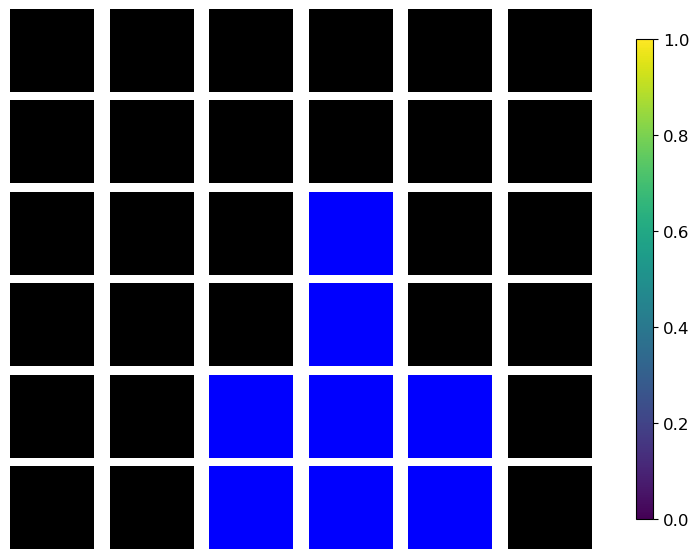

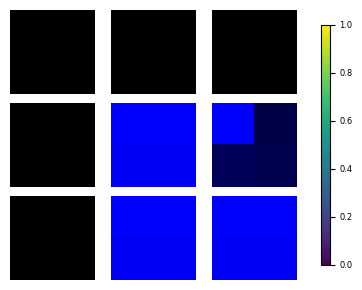

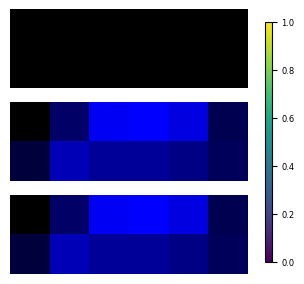

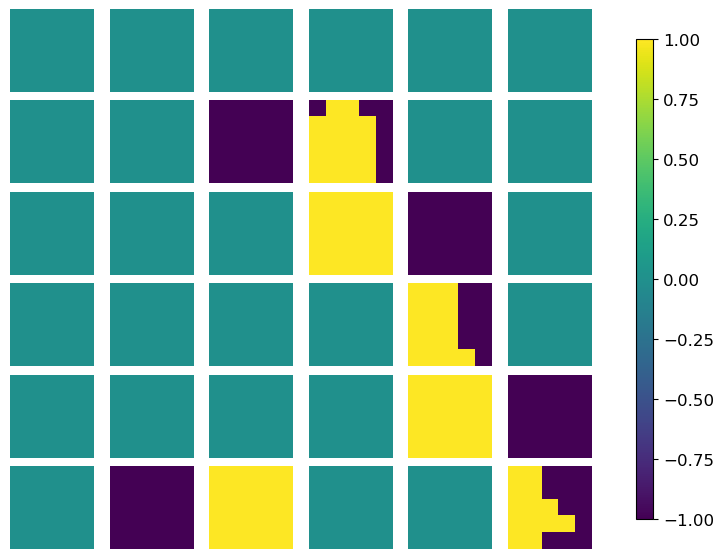

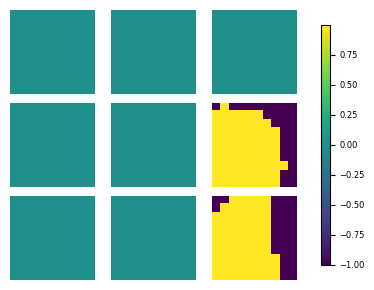

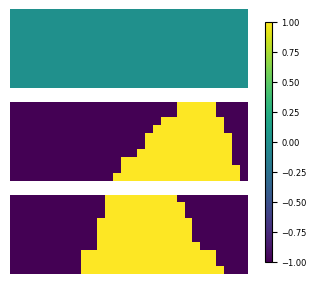

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


def get_reduced_cam(cam, output_shape):
    n, m = cam.shape
    target_n, target_m = output_shape

    # 沿著兩個維度進行不均勻分割
    split_n = np.array_split(np.arange(n), target_n)
    split_m = np.array_split(np.arange(m), target_m)

    # 對每個區塊取平均
    reduced_cam = np.array([
        np.mean(cam[np.ix_(rows, cols)])
        for rows in split_n
        for cols in split_m
    ]).reshape(output_shape)

    return reduced_cam

def plot_RM_CI_with_cam_mask(RM_CI, cam, save_path):
    output_shape = (RM_CI.shape[0], RM_CI.shape[1])
    resize_cam = get_reduced_cam(cam, output_shape)
    
    print(resize_cam)
    
    Threshold = 0.1
    # 找出 resize_cam 中小於 Threshold 的位置
    mask = resize_cam < Threshold

    # 將對應的 RM_CI 區塊全部設為 0
    RM_CI[mask] = 0

    plot_map(RM_CI, path=save_path + f'{name}_cam_RM_CI')
    print(save_path + f'{name}_cam_RM_CI')
    plot_heatmap(resize_cam, save_path = save_path + f'{name}_cam', title=f"Heatmap for {name}")

def plot_heatmap(resize_cam, save_path, title="Heatmap of resize_cam"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(resize_cam, annot=True, cmap="viridis", cbar=True, fmt=".2f")
    plt.title(title)
    plt.xlabel("m-axis")
    plt.ylabel("n-axis")
    
     # 儲存圖像
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # 關閉圖形，節省內存
    print(f"Heatmap saved to {save_path}")



RM_CI_save_path = f'{save_path}/RM_CIs/'
os.makedirs(RM_CI_save_path, exist_ok=True)


for name, RM_CI in RM_CIs.items():
    print(f"{name}, {RM_CI.shape}, {cams[name].shape}")
    
    plot_RM_CI_with_cam_mask(RM_CI, cams[name], RM_CI_save_path)
    

In [ ]:
from utils import plot_combine_images

# 繪製圖
save_path = f'./detect/{config["dataset"]}_{checkpoint_filename}/example/'

cam_methods = [GradCAM]
# heatmap_methods = [GradCAM, HiResCAM, GradCAMPlusPlus, GradCAMElementWise, XGradCAM, AblationCAM,
#                    ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, KPCA_CAM]
  
    
heatmap_save = f'{save_path}/{label}/{i}/heatmap/'
os.makedirs(heatmap_save, exist_ok=True)
# heatmap_dir = os.path.join(save_path, 'heatmap')
# os.makedirs(heatmap_dir, exist_ok=True)

for method in cam_methods:
    # try:
    cams = get_each_layers_cam(
        model = model, 
        target_layers = heatmap_layers, 
        label = label,
        input_tensor = image,
        cam_method = method)
    
    # plot_cams_on_image(image, cams, heatmap_dir, method.__name__)
            